In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation


2024-01-03 23:16:40.794085: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-03 23:16:40.810643: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-03 23:16:40.899124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 23:16:40.899176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 23:16:40.914023: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:100]}

In [3]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

%set_env TF_GPU_ALLOCATOR=cuda_malloc_async

env: TF_GPU_ALLOCATOR=cuda_malloc_async


In [3]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

label_features=['EW_Node_Location']


ds_gen = datahandler.DatasetGenerator(split_df=some_dataframes, input_features=input_features_reduced,
                                      label_features=label_features,
                                      train_val_split=0.85, stride=1, padding=False,
                                      input_history_steps=40, input_future_steps=120, seed=69)

=========================Creating Dataset=========================
Seed: 69
nTrain: 85 nVal: 15 (0.85)
Padding: False
Scaling: True
Labels: ['EW_Node_Location']


2024-01-03 23:18:09.738734: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-03 23:18:09.739050: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


=========================Finished Dataset=========================


In [4]:
train_combined, val_combined = ds_gen.get_datasets(512, label_features=label_features, shuffle=True)
print(train_combined.element_spec)

(TensorSpec(shape=(None, 160, 9), dtype=tf.float64, name=None), {'EW_Node_Location': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 160, 9)]          0         
                                                                 
 conv1d (Conv1D)             (None, 97, 64)            36928     
                                                                 
 conv1d_1 (Conv1D)           (None, 66, 32)            65568     
                                                                 
 flatten (Flatten)           (None, 2112)              0         
                                                                 
 dense (Dense)               (None, 64)                135232    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 EW_Node_Location (Dense)    (None, 2)                 66    

/home/user/Code/splid-challenge/base/prediction_models.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


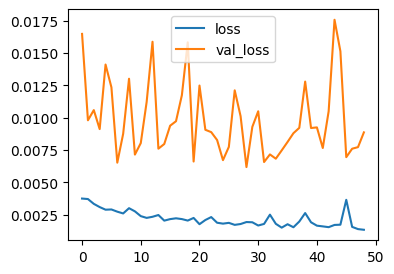

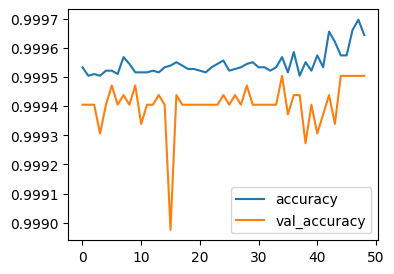

In [5]:
dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[64,64],[32,32]], dense_layers=[64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[30000,0.8], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)

dense_model.summary()
hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=50, verbose=1, plot_hist=False, callbacks=[])
dense_model.model.save_weights('tmp_model.hdf5')

dense_model.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
dense_model.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [6]:
dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[20,32],[10,32]], dense_layers=[128,64], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[20000,0.8], seed=0)
dense_model._model.load_weights('tmp_model.hdf5')

In [6]:
def localization_eval(ds_gen, gt_path, model, train=True, add_initial_node=False):

    t_ds, v_ds = ds_gen.get_datasets(512, label_features=label_features, shuffle=False, keep_identifier=True)
    ds = t_ds if train else v_ds

    ground_truth_labels = pd.concat([split_dataframes[k] for k in ds_gen.train_keys + ds_gen.val_keys])[['ObjectID', 'TimeIndex', 'EW_Node', 'EW_Type']].rename(columns={'EW_Node' : 'Node', 'EW_Type' : 'Type'})
    ground_truth_labels['Direction'] = 'EW' # For now just EW, see line above
    ground_truth_labels = ground_truth_labels[(ground_truth_labels['Direction'] == 'EW')]

    inputs = np.concatenate([element for element in ds.map(lambda x,y,z: x).as_numpy_iterator()])
    labels = np.concatenate([element['EW_Node_Location'] for element in ds.map(lambda x,y,z: y).as_numpy_iterator()])
    identifiers = np.concatenate([element for element in ds.map(lambda x,y,z: z).as_numpy_iterator()])

    # get predictions
    preds = model.predict(inputs)
    preds_argmax = np.argmax(preds, axis=1)

    df = pd.DataFrame(np.concatenate([identifiers.reshape(-1,2)], axis=1), columns=['ObjectID', 'TimeIndex'], dtype=np.int32)
    df['Location'] = labels
    df[f'Location_Pred'] = preds_argmax

    # add initial node prediction
    if add_initial_node:
        for obj in ds_gen.train_keys if train else ds_gen.val_keys:
            df = df.sort_index()
            df.loc[-1] = [int(obj), 0, 1, 1] # objid, timeindex, location, location_pred
            df.index = df.index + 1
            df = df.sort_index()
    
    df_filtered = df.loc[(df['Location_Pred'] == 1)]
    df_filtered = df_filtered.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)    

    # now, assign the real label to the locations
    mergeDf = df_filtered.merge(ground_truth_labels, how='left', on = ['ObjectID', 'TimeIndex'])

    ground_truth_from_file = pd.read_csv(gt_path).sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
    ground_truth_from_file = ground_truth_from_file[ground_truth_from_file['ObjectID'].isin(map(int, ds_gen.train_keys if train else ds_gen.val_keys))].copy()
    ground_truth_from_file = ground_truth_from_file[(ground_truth_from_file['Direction'] == 'EW')]

    evaluator = evaluation.NodeDetectionEvaluator(ground_truth_from_file, mergeDf)
    precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F2: {f2:.2f}')
    print(f'RMSE: {rmse:.4}')
    print(f'TP: {total_tp} FP: {total_fp} FN: {total_fn}')

    return df.loc[(df['Location'] == 1) | (df['Location_Pred'] == 1)].merge(ground_truth_labels, how='left', on = ['ObjectID', 'TimeIndex'])

In [7]:
eval_df = localization_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=False, add_initial_node=True)
# print(eval_df.head(50))

946/946 [==============================] - 2s 2ms/step
Precision: 0.91
Recall: 0.61
F2: 0.65
RMSE: 0.0
TP: 20 FP: 2 FN: 13


In [8]:
eval_df = localization_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=True, add_initial_node=True)

5364/5364 [==============================] - 13s 2ms/step
Precision: 0.82
Recall: 0.78
F2: 0.79
RMSE: 0.09091
TP: 121 FP: 27 FN: 34


In [10]:
false_preds = eval_df.loc[(eval_df['Location'] != eval_df['Location_Pred'])].sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
print(false_preds.head(80))
false_preds = eval_df[eval_df['Location'] != eval_df['Location_Pred']]
print(len(false_preds))
print(len(eval_df))

    ObjectID  TimeIndex  Location  Location_Pred Node Type Direction
0        106         69         0              1   AD   NK        EW
1        108        179         0              1   SS   NK        EW
2        114        201         0              1   AD   NK        EW
3        116        201         0              1   AD   NK        EW
4        117        461         0              1   AD   NK        EW
5        123        125         0              1   AD   NK        EW
6        124        367         0              1   AD   NK        EW
7        129        972         1              0   IK   CK        EW
8        130         86         1              0   IK   CK        EW
9        131        155         0              1   AD   NK        EW
10       135        936         1              0   IK   CK        EW
11       139       1009         1              0   AD   NK        EW
12       139       1098         1              0   IK   CK        EW
13       141        157         1 